In [1]:
import glob, os, json
import pandas as pd
import numpy as np

# Please see this github repo for download and install seahorse library:
# https://github.com/jsgounot/Seahorse
from seahorse import Graph, SContainer
from seahorse import constants, sns
constants.SHOWMODE = True

dname = os.path.dirname
bname = os.path.basename

cpal = ["#90ee90", "#6495ed", "#ca472f", "#f6c85f", "#6f4e7c", "#ffa056", "#558254", "#4ad9e1"]
cpal2 = ['#cecece', '#a559aa', '#59a89c', '#f0c571', '#e02b35', '#082a54']

pd.options.display.max_columns = None

import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none' # Output SVG with text as text, not curves
mpl.rcParams['savefig.transparent'] = True # Save w/ transparent background by default

In [2]:
import tarfile
import fnmatch
import re
import gzip

all_sites = ['Ac', 'Ax', 'Ch', 'Fo', 'Ll', 'Ps', 'Sc', 'Ub', 'Vf']

def read_from_tar(fname, pattern, sfun=None, ** kwargs):
    df = []
    with tarfile.open(fname, "r:*") as tar:
        for fname in tar.getnames():
            # print (fname)
            if fnmatch.fnmatch(fname, pattern):
                f = tar.extractfile(fname)
                if fname.endswith('.gz'):
                    with gzip.open(f, 'rt') as fg:
                        sdf = pd.read_csv(fg, ** kwargs)
                else:
                    sdf = pd.read_csv(f, ** kwargs)
                if sfun is not None: sdf = sfun(sdf, fname)                        
                df.append(sdf)
    return pd.concat(df)

def label_sdf(sdf, fname):
    fname = fname.split('/')
    fcat, site, transform, model = fname[-4:]
    model = model[:-11]
    sdf['fcat'], sdf['site'], sdf['transform'], sdf['model'] = fcat, site, transform, model 
    return sdf

def read_metadata_imp_from_tar(fname, fcat, transform, model, force=False):  
    basename = os.path.basename(fname)[:-7]
    imp = read_from_tar(fname, f'{basename}/{fcat}/*/{transform}/{model}.imp.tsv.gz', 
                        label_sdf, sep='\t')
    
    return imp

# Main figures

## Figure 4.D

In [3]:
fname = '../../Data/4_ml/Main/metadata_pred_strict_woreplacement_smote.tsv.gz'
df = pd.read_csv(fname, sep='\t', index_col=0)

df['transform'] = df['transform'].str.upper()
df['site'] = df['site'].str.upper()
df.head()

,fit_time,score_time,test_roc_auc_scorer,test_accuracy,test_f1_score,test_domprc,test_aps,model,site,transform,fcat
0,0.060735,0.005640,0.734375,0.722222,0.556650,0.722222,0.419048,LogisticRegression,AC,RAW,Demographic
1,0.100154,0.005274,0.832258,0.750000,0.577575,0.777778,0.498095,LogisticRegression,AC,RAW,Demographic
2,0.060684,0.005051,0.700000,0.722222,0.556650,0.750000,0.302663,LogisticRegression,AC,RAW,Demographic
3,0.061690,0.004966,0.754839,0.666667,0.555556,0.638889,0.524959,LogisticRegression,AC,RAW,Demographic
4,0.055971,0.004926,0.943548,0.828571,0.732143,0.714286,0.761111,LogisticRegression,AC,RAW,Demographic


In [4]:
from scipy.stats import ttest_1samp, ttest_ind

def fun(ssdf, alternative='greater'):
    a = ssdf['test_roc_auc_scorer']
    stats = ttest_1samp(a, popmean=0.5, alternative=alternative)
    stats = {'ttest_1samp_stat': stats[0], 'ttest_1samp_pvalue': stats[1]}
    
    # Make a random normal distribution with mean of 0.5, a size similar to what we have before, and and std similar as well (we might want to change that)
    mu, sigma = 0.05, a.std()
    b = np.random.normal(mu, sigma, len(stats))
    stats2 = ttest_ind(a, b, equal_var=False, alternative=alternative)
    stats2 = {'ttest_ind_stat': stats2[0], 'ttest_ind_pvalue': stats2[1]}

    stats.update(stats2)
    
    return pd.Series(stats)

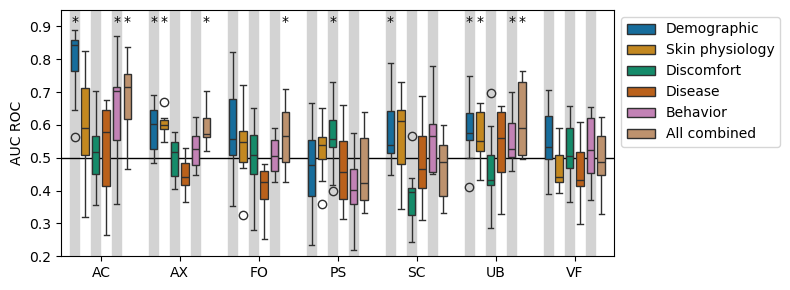

In [5]:
model, transform = 'RandomForestClassifier', 'RAW'
sdf = df[(df['model'] == model) & (df['transform'] == transform)]

sfun = lambda sdf: fun(sdf, alternative='greater')

stats = sdf.groupby(['model', 'site', 'transform', 'fcat'])[['test_roc_auc_scorer']].apply(sfun)
stats = stats.reset_index()

#significant = stats[stats['ttest_1samp_pvalue'] <= 0.05]
sdf = sdf.merge(stats, on=['model', 'site', 'transform', 'fcat'], how='inner')
sdf = sdf.sort_values(['model', 'site', 'transform', 'fcat'])

fcat_cat = {
    'Demographic': 'Demographic',
    'SkinPhysio': 'Skin physiology',
    'SkinSubclinical': 'Discomfort',
    'SkinTreatment': 'Disease',
    'SkinBehavior': 'Behavior',
    'all': 'All combined'
}


sdf['fcat'] = pd.Categorical(sdf['fcat'].map(fcat_cat), categories=fcat_cat.values())
cpal = sns.color_palette('colorblind')

graph = Graph(sdf)
graph.ax.plot((-.7, 6.7), (0.5, 0.5), '-', color='black', linewidth=1)
graph.sns.boxplot(x='site', y='test_roc_auc_scorer', hue='fcat', 
                  boxprops={'zorder': 2}, palette=cpal[:6],)

def hue_annot(graph, nhue, annotations, yvalue, span_frac=.8, boxplot_width=0.8):
    xticks = graph.ax.get_xticks()
    relative_centers = [i / (nhue * 2) for i in range((nhue * 2) + 1)][1::2]
    lpad = (1 - boxplot_width) / 2 # left pad
    
    for tick in xticks:       
        for idx, rcenter in enumerate(relative_centers):
            center = lpad + (boxplot_width * rcenter) - 0.5 + tick
            text = annotations[(tick * nhue) + idx]
            graph.ax.text(center, yvalue, text, ha='center')
    
stats['annot'] = np.where(stats['ttest_1samp_pvalue'] <= 0.05, '*', '')
stats['fcat'] = pd.Categorical(stats['fcat'].map(fcat_cat), categories=fcat_cat.values())
stats = stats.sort_values(['site', 'fcat'])

graph.change_boxplot_width(fraction=0.7)
graph.hue_xspan(6, color='lightgrey', zorder=1)
hue_annot(graph, 6, list(stats['annot']), .9)

graph.ax.set_xlabel('')
graph.ax.set_ylabel('AUC ROC')
graph.legend_outside(title='')
graph.ax.set_ylim(.2, .95)

graph.set_size_inches(8, 3)
graph.tight_layout()

In [6]:
fname = '../../Data/4_ml/Main/metadata_pred_strict_woreplacement_smote.tar.gz'

site, transform, model = 'Ac', 'raw', 'RandomForestClassifier'
fcat = 'Demographic'

imp = read_metadata_imp_from_tar(fname, fcat, transform, model)
imp['index'] = range(0, len(imp))
imp = imp.melt(id_vars=['fcat', 'site', 'transform', 'model', 'index'])

fun = lambda name: name.split('__')[0]
imp['feature'] = imp['variable'].apply(fun)
imp['value'] = imp['value'].abs()

simp = imp[imp['site'] == site]
simp.groupby(['fcat', 'site', 'transform', 'model', 'feature'])['value'].describe()

count  \
fcat        site transform model                  feature                           
Demographic Ac   raw       RandomForestClassifier Age                        10.0   
                                                  Current_smoking_status     10.0   
                                                  Ethnicity                  30.0   
                                                  Gender                     20.0   
                                                  Monthly_household_income   30.0   

                                                                                mean  \
fcat        site transform model                  feature                              
Demographic Ac   raw       RandomForestClassifier Age                       0.213006   
                                                  Current_smoking_status    0.000000   
                                                  Ethnicity                 0.122501   
                                                  Gender                    0.095554   
                                                  Monthly_household_income  0.076128   

                                                                                 std  \
fcat        site transform model                  feature                              
Demographic Ac   raw       RandomForestClassifier Age                       0.052385   
                                                  Current_smoking_status    0.000000   
                                                  Ethnicity                 0.064633   
                                                  Gender                    0.031731   
                                                  Monthly_household_income  0.043151   

                                                                                 min  \
fcat        site transform model                  feature                              
Demographic Ac   raw       RandomForestClassifier Age                       0.135263   
                                                  Current_smoking_status    0.000000   
                                                  Ethnicity                 0.037265   
                                                  Gender                    0.050919   
                                                  Monthly_household_income  0.012279   

                                                                                 25%  \
fcat        site transform model                  feature                              
Demographic Ac   raw       RandomForestClassifier Age                       0.189486   
                                                  Current_smoking_status    0.000000   
                                                  Ethnicity                 0.055517   
                                                  Gender                    0.070639   
                                                  Monthly_household_income  0.038548   

                                                                                 50%  \
fcat        site transform model                  feature                              
Demographic Ac   raw       RandomForestClassifier Age                       0.208357   
                                                  Current_smoking_status    0.000000   
                                                  Ethnicity                 0.132903   
                                                  Gender                    0.091307   
                                                  Monthly_household_income  0.076101   

                                                                                 75%  \
fcat        site transform model                  feature                              
Demographic Ac   raw       RandomForestClassifier Age                       0.244540   
                                                  Current_smoking_status    0.000000   
                                           

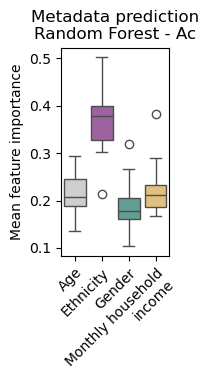

In [7]:
simp = imp[imp['site'] == site]
simp = simp.sort_values('feature')

# here we sum the (absolute) value of each variable from the same feature
# otherwise one-hot feature are not compared correctly
simp = simp.groupby(['fcat', 'site', 'transform', 'model', 'feature', 'index'])['value'].sum().reset_index()

simp['tvalue'] = simp.groupby(['fcat', 'site', 'transform', 'model', 'feature'])['value'].transform('sum')
simp = simp[simp['tvalue'] != 0]

graph = Graph(simp)

cpal = sns.color_palette('colorblind')
graph.sns.boxplot(x='feature', y='value', hue='feature', palette=cpal2[:4])

graph.ax.set_ylabel('Mean feature importance')
graph.ax.set_xlabel('')

def format_xlabel(label, msize=20):
    label = label.split('_')
    s = []
    for element in label:
        if not s:
            s.append(element)
        elif len(s[-1] + ' ' + element) <= msize:
            s[-1] += ' ' + element
        else:
            s.append(element)
    return '\n'.join(s)

graph.apply_xticklabels(format_xlabel, rotation=45, rotation_mode='anchor', ha='right', va='top')
graph.ax.set_title('Metadata prediction\nRandom Forest - Ac')

graph.set_size_inches(2, 4)
graph.tight_layout()

## Figure 4.E

In [8]:
fname = '../../Data/4_ml/Main/pathway_pred_cats_smote.tsv.gz'
df = pd.read_csv(fname, sep='\t', index_col=0)

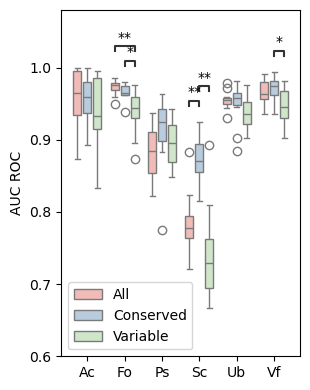

In [9]:
model, transform = 'Ridge', 'mms'

ssdf = df[(df['transform'] == transform) & (df['model'] == model)]
ssdf = ssdf[ssdf['site'] != 'Ax']

mapper = {'Core': 'Conserved', 'Accessory': 'Variable', 'All': 'All'}
ssdf['category'] =  ssdf['category'].apply(lambda cat: mapper[cat])
ssdf = ssdf.sort_values(['site', 'category'])

cpalt = ['#fbb4ae', '#b3cde3', '#ccebc5']

graph = Graph(ssdf)
graph.sns.boxplot(x='site', y='test_roc_auc_scorer', hue='category', palette=cpalt)
graph.make_annot(x='site', y='test_roc_auc_scorer', hue='category', verbose=0)

graph.ax.set_xlabel('')
graph.ax.set_ylabel('AUC ROC')
graph.ax.legend(title='')
graph.change_boxplot_width(.8)
graph.ax.set_ylim(0.6, 1.08)

graph.set_size_inches(3.2, 4)
graph.tight_layout()

## Figure 4.F

In [10]:
fname = '../../Data/4_ml/Main/dermotypes_cross_sites_pred_smote.tsv.gz'
cs = pd.read_csv(fname, sep='\t', index_col=0)

for site in all_sites:
    cs[site] = cs[site].fillna(0).astype(int)

def get_predictor(row):
    predictor = None
    for site, value in row.items():
        if value == 0:
            continue
        elif value == 1:
            assert predictor is None
            predictor = site
        else:
            raise Exception(value)
    return predictor

cs = cs[cs[all_sites].sum(axis=1) == 1]
cs['training'] = cs[all_sites].apply(get_predictor, axis=1)
cs.columns = ['target' if cname == 'site' else cname for cname in cs.columns]

cnames = ['fit_time', 'score_time', 'test_roc_auc_scorer', 'test_accuracy',
       'test_f1_score', 'test_domprc', 'test_aps', 'model', 'target',
       'training', 'transform']

cs = cs[cnames]
cs['group'] = 'AllSpecies'
cs.head(5)

,fit_time,score_time,test_roc_auc_scorer,test_accuracy,test_f1_score,test_domprc,test_aps,model,target,training,transform,group
0,0.798772,0.013086,0.362790,0.07500,0.070000,0.30000,0.190566,LogisticRegression,Ax,Ac,raw,AllSpecies
1,0.877726,0.013156,0.494316,0.25000,0.215741,0.32500,0.230469,LogisticRegression,Ax,Ac,raw,AllSpecies
2,0.872753,0.012755,0.554377,0.25000,0.219321,0.30000,0.288054,LogisticRegression,Ax,Ac,raw,AllSpecies
3,0.799970,0.014227,0.545233,0.32500,0.280403,0.35000,0.256601,LogisticRegression,Ax,Ac,raw,AllSpecies
4,0.906295,0.012545,0.493495,0.25641,0.219786,0.25641,0.239023,LogisticRegression,Ax,Ac,raw,AllSpecies


In [11]:
fname = '../../Data/4_ml/Main/dermotypes_cross_sites_pred_single_top_10_smote.tsv.gz'
df = pd.read_csv(fname, sep='\t', index_col=0)
df['group'] = 'Top10'
df.head(5)

,fit_time,score_time,test_roc_auc_scorer,test_accuracy,test_f1_score,test_domprc,test_aps,model,target,training,transform,group
0,1.698915,0.006424,0.576840,0.512500,0.449832,0.512500,0.313984,LogisticRegression,Ac,Ax,raw,Top10
1,0.075298,0.005611,0.483766,0.637500,0.508370,0.687500,0.241991,LogisticRegression,Ac,Ax,raw,Top10
2,0.071394,0.006288,0.579004,0.637500,0.508370,0.687500,0.235868,LogisticRegression,Ac,Ax,raw,Top10
3,0.089022,0.005294,0.593240,0.607595,0.518387,0.594937,0.277935,LogisticRegression,Ac,Ax,raw,Top10
4,0.086548,0.005304,0.752914,0.683544,0.600607,0.620253,0.467997,LogisticRegression,Ac,Ax,raw,Top10


In [12]:
model, transform, metric = 'RandomForestClassifier', 'raw', 'test_roc_auc_scorer'
sdf = df[(df['model'] == model) & (df['transform'] == transform)]
sdf = sdf.groupby(['target', 'training', 'model', 'transform'])[metric].mean()
sdf = sdf.reset_index()
sdf['rank'] = sdf.groupby('target')[metric].transform(lambda serie: serie.rank(ascending=False))
sdf = sdf[sdf['rank'] == 1]
mapper = sdf.set_index('target')['training'].to_dict()
mapper

{'Ac': 'Ub',
 'Ax': 'Ub',
 'Fo': 'Ll',
 'Ps': 'Sc',
 'Sc': 'Vf',
 'Ub': 'Fo',
 'Vf': 'Ub'}

In [13]:
def label_sdf(sdf, fname):
    sdf = sdf.melt(var_name='name', value_name='importance')
    fname = fname.split('/')
    target, training = fname[1], fname[2]
    sdf['target'], sdf['training'] = target, training
    return sdf

model, transform = 'RandomForestClassifier', 'raw'
fname = '../../Data/4_ml/Main/dermotypes_cross_sites_pred_single_top_10_smote.tar.gz'
imp = read_from_tar(fname, f'dermotypes_cross_sites_pred_single_top_10_smote/*/*/{transform}/{model}.imp.tsv.gz', 
                        label_sdf, sep='\t')

imp = imp.groupby(['target', 'training', 'name'])['importance'].mean().reset_index()
imp['importance'] = imp['importance'] / imp.groupby(['target', 'training'])['importance'].transform('sum')
imp.head(5)

,target,training,name,importance
0,Ac,Ax,s__Corynebacterium_pseudogenitalium,0.104912
1,Ac,Ax,s__Corynebacterium_tuberculostearicum,0.086013
2,Ac,Ax,s__Cutibacterium_acnes,0.124533
3,Ac,Ax,s__Cutibacterium_avidum,0.083647
4,Ac,Ax,s__Dermabacter_sp_HFH0086,0.127607


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Ax_AllSpecies vs. Ax_Top10: Mann-Whitney-Wilcoxon test two-sided, P_val:2.600e-06 U_stat=9.040e+02
Fo_AllSpecies vs. Fo_Top10: Mann-Whitney-Wilcoxon test two-sided, P_val:1.393e-02 U_stat=1.331e+03
Sc_AllSpecies vs. Sc_Top10: Mann-Whitney-Wilcoxon test two-sided, P_val:2.393e-03 U_stat=1.221e+03
Ub_AllSpecies vs. Ub_Top10: Mann-Whitney-Wilcoxon test two-sided, P_val:8.034e-03 U_stat=1.294e+03
Vf_AllSpecies vs. Vf_Top10: Mann-Whitney-Wilcoxon test two-sided, P_val:1.107e-02 U_stat=1.316e+03


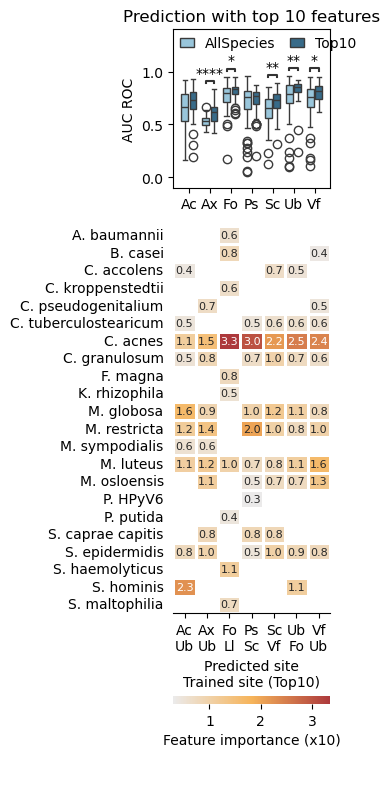

In [14]:
scs = pd.concat([cs, df])
scs['best'] = scs['target'].map(mapper)
scs = scs[scs['training'] == scs['best']]
scs = scs.sort_values(['group', 'target'])

simp = imp.copy()
simp['best'] = simp['target'].map(mapper)
simp = simp[simp['training'] == simp['best']]
simp['label'] = simp['target'] + '\n' + simp['training']
simp['name'] = simp['name'].apply(lambda name: name[3:].replace('_', ' '))
simp = simp.pivot_table(index='name', columns='label', values='importance')
simp = simp * 10

# ------------
sc = SContainer(None, 4, 1)
cmapt = ['#8ecae6', '#2a6f97']

graph = sc.graph((0, 0), scs)
graph.sns.boxplot(x='target', y='test_roc_auc_scorer', hue='group', palette=cmapt)
graph.make_annot(x='target', y='test_roc_auc_scorer', hue='group')

graph.change_boxplot_width(.8)
graph.ax.legend(title='', handlelength=1, ncols=2, columnspacing=1, loc=2, borderaxespad=0.1, frameon=False)
graph.ax.set_ylim((-0.1, 1.4))
graph.ax.set_xlabel('')
graph.ax.set_ylabel('AUC ROC')
graph.ax.set_title('Prediction with top 10 features')

# ------------

from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

cvals  = [0, 0.3, 0.6]
colors = ["#EBEAEA", "#F6B45A", "#AD393C"]
norm = Normalize(min(cvals), max(cvals))
tuples = list(zip(map(norm, cvals), colors))
cmap = LinearSegmentedColormap.from_list("", tuples)

# ------------

graph = sc.graph((slice(1, 4), 0), simp)

#cmap = sns.color_palette("Reds", as_cmap=True)

graph.sns.heatmap(annot=True, fmt='.1f', cmap=cmap, linewidth=1, cbar=True,
                  cbar_kws={'label': 'Feature importance (x10)', 'orientation': 'horizontal'},
                  annot_kws={'size': 8, 'va': 'center'}
                 )

graph.ax.set_xlabel('Predicted site\nTrained site (Top10)')
graph.ax.set_ylabel('')

def rename_species(name):
    name = name.strip().split()
    name = name[0][0] + '. ' + ' '.join(name[1:])
    return name
    
graph.apply_yticklabels(rename_species)

sns.despine(ax=graph.ax, left=True)
graph.ax.tick_params(left=False) 

sc.set_size_inches(3.5, 8)
sc.tight_layout()

## Figure 4.G

In [15]:
fname = '../../Data/4_ml/Main/dermotypes_cross_sites_pred_labels_poh_stablefeat_stablelab_smote.tsv.gz'
df = pd.read_csv(fname, sep='\t', index_col=0)

sites = ['Ac', 'Ax', 'Fo', 'Ps', 'Sc', 'Ub', 'Vf']
df[sites] = df[sites].fillna(0).astype(int)
df['nsites'] = df[sites].sum(axis=1)

df.head()

,fit_time,score_time,test_roc_auc_scorer,test_accuracy,test_f1_score,test_domprc,test_aps,model,site,transform,nrows,icount,fcount,Ax,Fo,Ps,Sc,Ub,Vf,Ac,nsites
0,1.668193,0.007248,0.658621,0.676471,0.568627,0.647059,0.887103,LogisticRegression,Ac,raw,167,1618,167,1,0,0,0,0,0,0,1
1,0.070110,0.005493,0.727586,0.705882,0.591346,0.676471,0.935180,LogisticRegression,Ac,raw,167,1618,167,1,0,0,0,0,0,0,1
2,0.056821,0.005122,0.784483,0.787879,0.664731,0.727273,0.956076,LogisticRegression,Ac,raw,167,1618,167,1,0,0,0,0,0,0,1
3,0.058577,0.005077,0.715517,0.606061,0.546032,0.515152,0.953977,LogisticRegression,Ac,raw,167,1618,167,1,0,0,0,0,0,0,1
4,0.054359,0.005253,0.417857,0.636364,0.505000,0.666667,0.823485,LogisticRegression,Ac,raw,167,1618,167,1,0,0,0,0,0,0,1


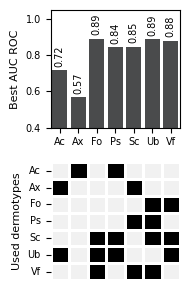

In [16]:
group = ['model', 'site', 'transform'] + sites
sdf = df.groupby(group)['test_roc_auc_scorer'].describe()
sdf = sdf.reset_index()
sdf['nsites'] = sdf[sites].sum(axis=1)

selected_model = 'LogisticRegression'
sdf = sdf[sdf['model'] == selected_model]
sdf = sdf[sdf['mean'] == sdf.groupby('site')['mean'].transform('max')]

sc = SContainer(None, 2, 1)

graph = sc.graph(0, sdf)
graph.sns.barplot(x='site', y='mean', color='#494B4D')
fn = lambda value: f'{value:.2f}'
graph.barplot_add_value(fntxt=fn, rotation=90, kwg_text={'size': 7})

graph.ax.set_xlabel('')
graph.ax.set_ylabel('Best AUC ROC', size=8)
graph.apply_xticklabels(size=7)
graph.apply_yticklabels(size=7)
graph.ax.set_ylim((0.4, 1.05))

ssdf = sdf.sort_values('site')[sites].T
graph = sc.graph(1, ssdf)

cmap = sns.color_palette("light:black", as_cmap=True)
graph.sns.heatmap(cmap=cmap, cbar=False, linewidth=1, vmin=0, vmax=1)

graph.ax.set_ylabel('Used dermotypes', size=8)
graph.apply_yticklabels(size=7, rotation=0)
graph.remove_xticks()

sc.set_size_inches(2, 3)
sc.tight_layout()

## Supplementary figures 18

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

real vs. random: Mann-Whitney-Wilcoxon test two-sided, P_val:1.292e-13 U_stat=8.031e+03


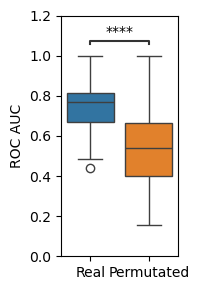

In [17]:
fname = '../../Data/4_ml/Main/metadata.ac.demographic.permutation.tsv'
df = pd.read_csv(fname, sep='\t')
graph = Graph(df)

graph.sns.boxplot(x='rtype', y='test_roc_auc_scorer', hue='rtype')
graph.make_annot(x='rtype', y='test_roc_auc_scorer')

graph.ax.set_xlabel('')
graph.ax.set_ylabel('ROC AUC')
graph.apply_xticklabels({
    'real': 'Real',
    'random': 'Permutated'
})

graph.ax.set_ylim(0, 1.2)
graph.set_size_inches(2, 3)
graph.tight_layout()

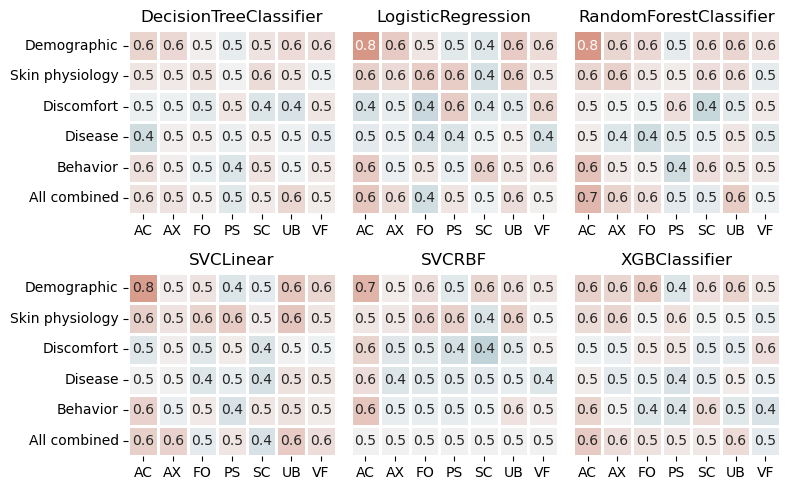

In [18]:
fname = '../../Data/4_ml/Main/metadata_pred_strict_woreplacement_smote.tsv.gz'
df = pd.read_csv(fname, sep='\t', index_col=0)

df['transform'] = df['transform'].str.upper()
df['site'] = df['site'].str.upper()
df = df[df['model'] != 'Ridge']

fcat_cat = {
    'Demographic': 'Demographic',
    'SkinPhysio': 'Skin physiology',
    'SkinSubclinical': 'Discomfort',
    'SkinTreatment': 'Disease',
    'SkinBehavior': 'Behavior',
    'all': 'All combined'
}


df['fcat'] = pd.Categorical(df['fcat'].map(fcat_cat), categories=fcat_cat.values())

sc = SContainer(None, 2, 3)

idx = 0
for model, sdf in df.groupby('model'):
    sdf = sdf[sdf['transform'] == 'RAW'].copy()
    sdf = sdf.pivot_table(index='fcat', columns='site', 
                          values='test_roc_auc_scorer', aggfunc='mean',
                          observed=True)

    graph = sc.graph(idx, sdf)
    idx += 1
    
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    kwargs = {}
    
    graph.sns.heatmap(annot=True, fmt='.1f', cmap=cmap, linewidth=1,
                     vmin=0, vmax=1, cbar=False)

    graph.ax.set_xlabel('')
    graph.ax.set_ylabel('')
    graph.ax.set_title(f'{model}')

    if idx == 1 or idx == 4:
        graph.apply_yticklabels(rotation=0)
    else:
        graph.remove_yticks()
        
sc.set_size_inches(8, 5)
sc.tight_layout()

## Supplementary Figure 19

/Users/ericejs/miniforge3/lib/python3.12/site-packages/seahorse/core/figure.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()


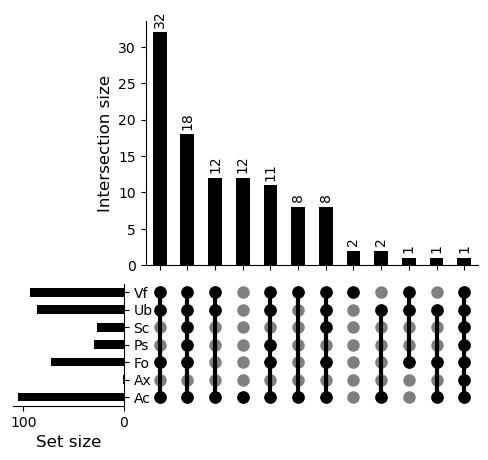

In [19]:
from seahorse import PyUpset

fname = '../../Data/4_ml/Main/pathway_meta.pcat.tsv.gz'
pcat = pd.read_csv(fname, sep='\t', index_col=0)
pcatc = pcat[pcat['Category'] == 'Core']

graph = PyUpset(pcatc, key="Pathway", value="Site", griddots=True, maxwidth=12, 
                boxratio=(None, (2, 1)))

graph.set_size_inches(6, 5)
graph.tight_layout()

In [20]:
def label_sdf(sdf, fname):
    fname = fname.split('/')
    site, transform, fcat, model = fname[-4:]
    model = model[:-11]
    sdf['fcat'], sdf['site'], sdf['transform'], sdf['model'] = fcat, site, transform, model 
    return sdf

def read_pathway_imp_from_tar(fname, fcat, transform, model, force=False):    
    basename = os.path.basename(fname)[:-7]
    imp = read_from_tar(fname, f'{basename}/*/{transform}/{fcat}/{model}.imp.tsv.gz', 
                        label_sdf, sep='\t')
    return imp

fname = '../../Data/4_ml/Main/pathway_pred_cats_smote.tar.gz'
imp = read_pathway_imp_from_tar(fname, 'Core', 'mms', 'Ridge')
imp = imp.melt(id_vars=['fcat', 'site', 'transform', 'model'])
imp.head()

,fcat,site,transform,model,variable,value
0,Core,Ac,mms,Ridge,pwy_0,-5.924583
1,Core,Ac,mms,Ridge,pwy_0,-5.933780
2,Core,Ac,mms,Ridge,pwy_0,1.305467
3,Core,Ac,mms,Ridge,pwy_0,-6.163095
4,Core,Ac,mms,Ridge,pwy_0,-3.702214


/Users/ericejs/miniforge3/lib/python3.12/site-packages/seahorse/core/graph.py:293: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.ax.set_yticklabels(nticks)


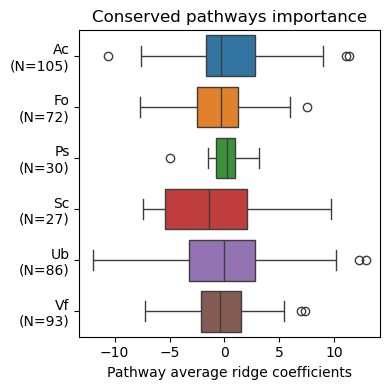

In [21]:
mimp = imp[~ imp['value'].isnull()]
mimp = mimp.groupby(['site', 'variable'])['value'].mean().reset_index()

graph = Graph(mimp)
graph.sns.boxplot(y='site', x='value', hue='site')

graph.ax.set_ylabel('')
graph.ax.set_xlabel('Pathway average ridge coefficients')
graph.ax.set_title('Conserved pathways importance')

graph.add_yticks_ncount('site')

graph.set_size_inches(4, 4)
graph.tight_layout()

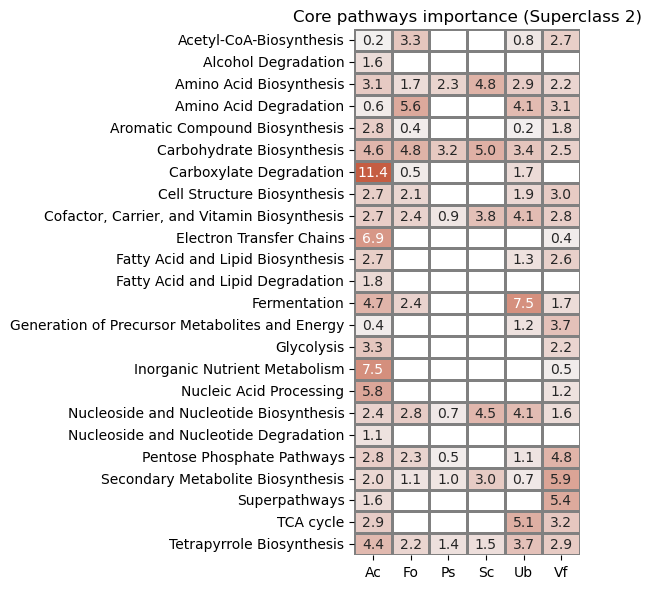

In [22]:
fname = '../../Data/4_ml/Main/pathway_meta.translator.tsv.gz'
translator = pd.read_csv(fname, sep='\t', index_col=0)
translator = translator.reset_index()
translator = translator.set_index('0')['index'].to_dict()

fname = '../../Data/4_ml/Main/metacyc_pwy_class.tsv'
pclass = pd.read_csv(fname, sep='\t')

mimp = imp[imp['fcat'] == 'Core'].groupby(['site', 'variable'])['value'].mean()
mimp = mimp.reset_index()
mimp['value_abs'] = mimp['value'].abs()
mimp['rank'] = mimp.groupby('site')['value_abs'].transform(lambda serie: serie.rank(ascending=False))
mimp = mimp.sort_values(['site', 'rank'])

mimp['pid'] = mimp['variable'].map(translator)
smimp = mimp.merge(pclass, on='pid', how='left')

mat = smimp.pivot_table(index='Superclass2', columns='site', values='value_abs', aggfunc='mean')

graph = Graph(mat)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
graph.sns.heatmap(linewidth=1, linecolor='grey', cmap=cmap,
                  annot=True, fmt='.1f', cbar=False, vmin=-12, vmax=12,
                 cbar_kws={'label': 'Average model coefficients'})

graph.apply_yticklabels(rotation=0)
graph.ax.set_xlabel('')
graph.ax.set_ylabel('')
graph.ax.set_title('Core pathways importance (Superclass 2)')

graph.set_size_inches(6, 6)
graph.tight_layout()

## Supplementary figure 20

In [23]:
fname = '../../Data/4_ml/Main/dermotypes_cross_sites_pred_smote.tsv.gz'
df = pd.read_csv(fname, sep='\t', index_col=0)

for site in all_sites:
    df[site] = df[site].fillna(0).astype(int)

metrics = ['test_accuracy', 'test_f1_score', 'test_roc_auc_scorer', 'test_aps']
sdf = df.groupby(all_sites + ['model', 'transform', 'site'])[metrics].mean().reset_index()
sdf.sort_values('test_roc_auc_scorer')

,Ac,Ax,Ch,Fo,Ll,Ps,Sc,Ub,Vf,model,transform,site,test_accuracy,test_f1_score,test_roc_auc_scorer,test_aps
243,0,0,0,0,0,1,0,0,0,SVCLinear,raw,Sc,0.733526,0.558214,0.217043,0.659984
1712,0,0,1,0,0,0,0,0,0,SVCLinear,raw,Ub,0.718462,0.549067,0.221948,0.731914
9769,1,1,1,0,0,0,0,0,0,SVCLinear,raw,Vf,0.705833,0.678349,0.223681,0.727953
3647,0,1,0,0,0,1,0,0,0,SVCLinear,raw,Sc,0.761026,0.642303,0.246200,0.664983
1713,0,0,1,0,0,0,0,0,0,SVCLinear,raw,Vf,0.595577,0.449254,0.246795,0.705840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2701,0,0,1,1,0,0,0,0,1,SVCLinear,raw,Ub,0.771218,0.677450,0.896954,0.815528
8479,1,0,1,1,0,1,1,0,1,SVCLinear,raw,Ub,0.821667,0.775642,0.897381,0.802698
2907,0,0,1,1,0,1,0,0,1,SVCLinear,raw,Ub,0.753782,0.643677,0.900329,0.809750
1265,0,0,0,1,0,1,1,0,1,SVCLinear,raw,Ub,0.748718,0.634645,0.900537,0.803100


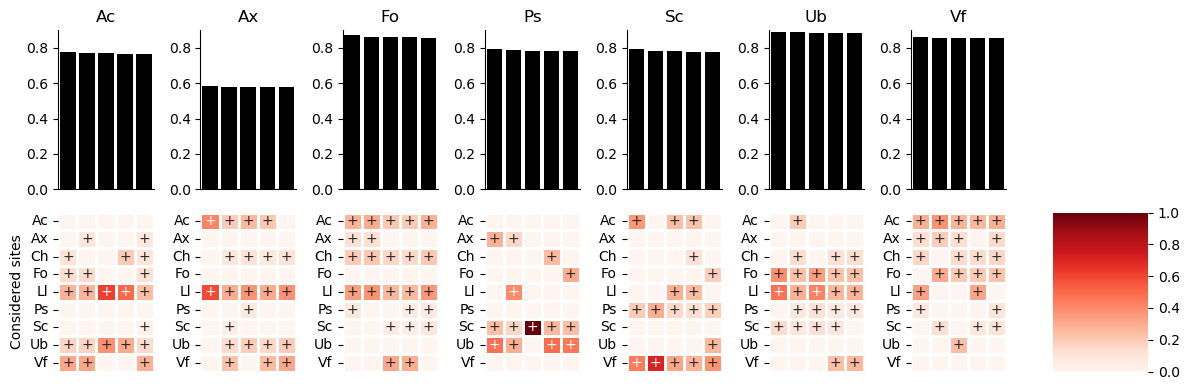

In [24]:
def make_scatter_sites_importance_hm(sdf, fname, model, transform, metric, ylabel=None, n=5, size=(12, 4)):

    sdf['rank'] = sdf.groupby(['model', 'site'])[metric].rank(method='dense', ascending=False)
    
    sites = ['Ac', 'Ax', 'Fo', 'Ps', 'Sc', 'Ub', 'Vf']
    imp = pd.read_csv(fname, sep='\t')
    
    for site in all_sites:
        imp[site] = imp[site].fillna(0).astype(int)
    
    cmerge = all_sites + ['model', 'transform', 'site']
    simp = imp.merge(sdf, on=cmerge, how='inner')

    for site in all_sites:
        simp[site] = simp['IMP_' + site].fillna(0)
        simp = simp.drop('IMP_' + site, axis=1)

    sc = SContainer(None, 2, len(sites)+1)

    vmin, vmax = simp[all_sites].min().min(), simp[all_sites].max().max()
    cmap = sns.color_palette("Reds", as_cmap=True)
    sites = sorted(simp['site'].unique())

    for site, idf in simp.groupby('site'):
        idx = sites.index(site)
        idf = idf.sort_values('rank', ascending=True)
        idf = idf.head(n)

        graph = sc.graph(idx, idf)
        graph.sns.barplot(x='rank', y=metric, color='black')
        graph.ax.set_title(site)
        graph.ax.set_ylim(0, .9)
        graph.remove_xticks()
        graph.ax.set_xlabel('')
        sns.despine(ax=graph.ax)

        if idx == 0:
            graph.ax.set_ylabel('')
        else:
            graph.ax.set_ylabel('')

        graph = sc.graph(idx + len(sites) + 1, idf[all_sites].T)

        annot = np.where(idf[all_sites].T > 0, '+', '')

        if idx == 6:
            cbar_ax = sc.graph(idx + len(sites) + 2).ax
            graph.sns.heatmap(vmin=vmin, vmax=vmax, cbar=True, cbar_ax=cbar_ax, linewidth=1, cmap=cmap, 
                              annot=annot, fmt='')
        else:    
            graph.sns.heatmap(vmin=vmin, vmax=vmax, cbar=False, linewidth=1, cmap=cmap, annot=annot, fmt='')

        graph.apply_yticklabels(rotation=0)
        graph.remove_xticks()

        if idx == 0:
            graph.ax.set_ylabel('Considered sites')

    sc.set_size_inches(* size)
    sc.tight_layout()
    
    return sc

fname = '../../Data/4_ml/Main/imp_cross.dermotypes_cross_sites_pred_smote.raw.RandomForestClassifier.tsv.gz'
sc = make_scatter_sites_importance_hm(sdf, fname, 'RandomForestClassifier', 
                                      'raw', 'test_roc_auc_scorer', 'Mean ROC AUC')

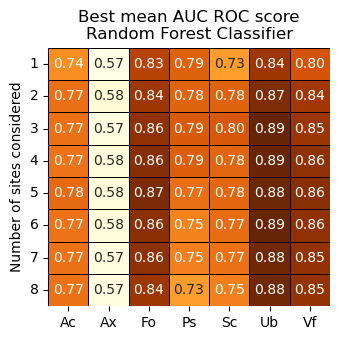

In [25]:
sdf['rank'] = sdf.groupby(['model', 'site'])['test_roc_auc_scorer'].rank(method='dense', ascending=False)

model = 'RandomForestClassifier'

ssdf = sdf[sdf['model'] == model].copy()
ssdf['nsites'] = ssdf[all_sites].sum(axis=1)
ssdf['rank'] = ssdf.groupby(['site', 'nsites'])['test_roc_auc_scorer'].rank(method='dense', ascending=False)
matrix = ssdf[ssdf['rank'] == 1].pivot_table(index='nsites', columns='site', values='test_roc_auc_scorer')

graph = Graph(matrix)

cmap = sns.diverging_palette(220, 20, as_cmap=True)
cmap = sns.color_palette("YlOrBr", as_cmap=True)

graph.sns.heatmap(annot=True, fmt='.2f', cbar=0, linewidth=0.5,
                 cmap=cmap, linecolor='black')

graph.ax.set_xlabel('')
graph.ax.set_ylabel('Number of sites considered')
graph.ax.set_title('Best mean AUC ROC score\nRandom Forest Classifier')
graph.apply_yticklabels(rotation=0)

graph.set_size_inches(3.5, 3.5)
graph.tight_layout()

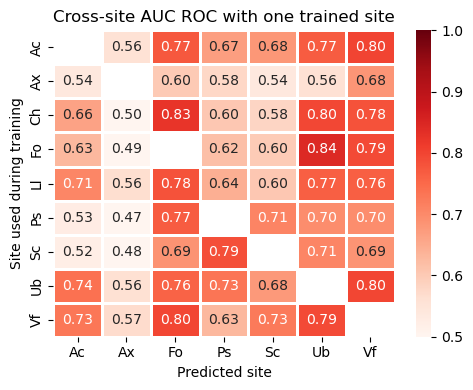

In [26]:
ssdf = sdf[(sdf['model'] == model) & (sdf['transform'] == transform)]
ssdf = ssdf[ssdf[all_sites].sum(axis=1) == 1]

def get_training(row):
    row = row.to_dict()
    value = [key for key, value in row.items() if value != 0]
    assert len(value) == 1
    return value[0]

ssdf['training'] = ssdf[all_sites].apply(get_training, axis=1)

def check_one(values):
    assert len(values) == 1
    return values.mean()

ssdf = ssdf.pivot_table(index='training', columns='site', values='test_roc_auc_scorer', aggfunc=check_one)

graph = Graph(ssdf)
cmap = sns.color_palette("Reds", as_cmap=True)
graph.sns.heatmap(annot=True, fmt='.2f', cmap=cmap, linewidth=1,
                 vmin=0.5, vmax=1, cbar=True)

graph.ax.set_xlabel('Predicted site')
graph.ax.set_ylabel('Site used during training')
graph.ax.set_title('Cross-site AUC ROC with one trained site')

graph.set_size_inches(5, 4)
graph.tight_layout()

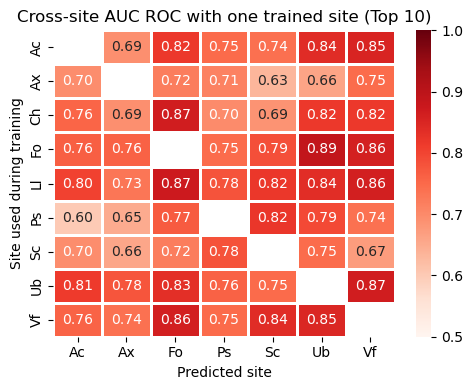

In [27]:
fname = '../../Data/4_ml/Main/dermotypes_cross_sites_pred_single_top_10_smote.tsv.gz'
df = pd.read_csv(fname, sep='\t', index_col=0)

model, transform, metric = 'RandomForestClassifier', 'raw', 'test_roc_auc_scorer'
sdf = df[(df['model'] == model) & (df['transform'] == transform)]
sdf = sdf.groupby(['target', 'training', 'model', 'transform'])[metric].mean()
sdf = sdf.reset_index()
sdf = sdf.pivot_table(index='training', columns='target', values=metric)

graph = Graph(sdf)
cmap = sns.color_palette("Reds", as_cmap=True)
graph.sns.heatmap(annot=True, fmt='.2f', cmap=cmap, linewidth=1,
                 vmin=0.5, vmax=1, cbar=True)

graph.ax.set_xlabel('Predicted site')
graph.ax.set_ylabel('Site used during training')
graph.ax.set_title('Cross-site AUC ROC with one trained site (Top 10)')

graph.set_size_inches(5, 4)
graph.tight_layout()